In [1]:
!pip install ultralytics roboflow albumentations opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 137.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


Оновлення бібліотек для уникнення помилок...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.3 MB/s eta 0:00:00

Потрібен ключ API (файл kaggle.json). Завантажте його зараз:


Saving kaggle.json to kaggle.json

Розпочинаю скачування набору даних vashchillya/mkr-datasett...
Dataset URL: https://www.kaggle.com/datasets/vashchillya/mkr-datasett
License(s): other
 95% 7.00M/7.33M [00:01<00:00, 8.36MB/s]
100% 7.33M/7.33M [00:01<00:00, 5.37MB/s]
Розпаковка архіву...
Операцію завершено! Файли готові.
Конфігурацію data.yaml успішно адаптовано!
Виявлені класи об'єктів: ['Volkswagen-logo']
Обрано зображення: frame_0291.jpg


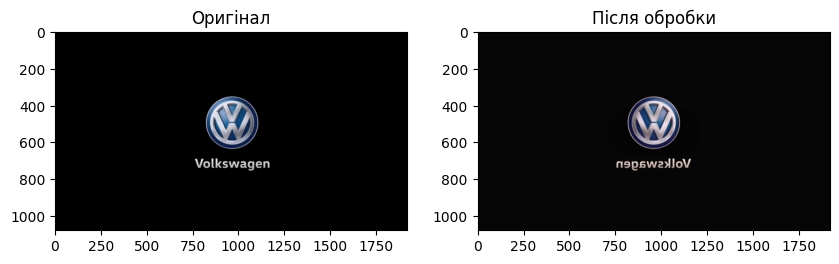

In [2]:
import os
from google.colab import files
import shutil
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import random
import yaml
import glob

print("Оновлення бібліотек для уникнення помилок...")
!pip install -q --upgrade kaggle
if os.path.exists("mkr-datasett.zip"):
    os.remove("mkr-datasett.zip")

print("\nПотрібен ключ API (файл kaggle.json). Завантажте його зараз:")
key_file = files.upload()

filename = list(key_file.keys())[0]
if filename != 'kaggle.json':
    os.rename(filename, 'kaggle.json')

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nРозпочинаю скачування набору даних vashchillya/mkr-datasett...")
!kaggle datasets download -d vashchillya/mkr-datasett --force

working_folder = "/content/mkr_project_data"

if os.path.exists(working_folder):
    shutil.rmtree(working_folder)
os.makedirs(working_folder, exist_ok=True)

print("Розпаковка архіву...")
!unzip -q mkr-datasett.zip -d {working_folder}
print("Операцію завершено! Файли готові.")



config_matches = glob.glob(f"{working_folder}/**/data.yaml", recursive=True)

if config_matches:
    current_config = config_matches[0]
    root_loc = os.path.dirname(current_config)

    with open(current_config, 'r') as file_stream:
        yolo_settings = yaml.safe_load(file_stream)

    yolo_settings['path'] = root_loc
    yolo_settings['train'] = "train/images"
    yolo_settings['val'] = "valid/images"

    if 'test' in yolo_settings:
        yolo_settings['test'] = "test/images"

    with open(current_config, 'w') as file_stream:
        yaml.dump(yolo_settings, file_stream)

    print("Конфігурацію data.yaml успішно адаптовано!")
    print(f"Виявлені класи об'єктів: {yolo_settings['names']}")
else:
    print("УВАГА: Файл конфігурації data.yaml відсутній!")



training_path = os.path.join(root_loc, "train", "images")
list_of_files = os.listdir(training_path)

if list_of_files:
    selected_file = random.choice(list_of_files)
    full_path = os.path.join(training_path, selected_file)

    original_pic = cv2.imread(full_path)
    original_pic = cv2.cvtColor(original_pic, cv2.COLOR_BGR2RGB)

    aug_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Rotate(limit=20, p=0.5),
        A.GaussianBlur(p=0.2),
        A.RGBShift(p=0.2),
        A.RandomFog(p=0.1),
        A.CLAHE(p=0.5),
        A.ChannelShuffle(p=0.1)
    ])

    augmented = aug_pipeline(image=original_pic)['image']

    print(f"Обрано зображення: {selected_file}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Оригінал")
    plt.imshow(original_pic)
    plt.subplot(1, 2, 2)
    plt.title("Після обробки")
    plt.imshow(augmented)
    plt.show()

else:
    print("Помилка: У вказаній директорії немає зображень.")

In [3]:
from ultralytics import YOLO

yolo_net = YOLO('yolo11n.pt')

config_path = '/content/mkr_project_data/data.yaml'

print(f"Розпочинаю навчання на конфігурації: {config_path}")

history = yolo_net.train(
    data=config_path,
    epochs=100,
    patience=0,
    batch=8,
    imgsz=640,
    name='mkr_new_run',
    optimizer='AdamW',
    lr0=0.001,
    exist_ok=True,
    verbose=True
)

print("Тренування завершено успішно!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Розпочинаю навчання на конфігурації: /content/mkr_project_data/data.yaml
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mkr_project_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fa

In [6]:
import os
import glob
import cv2
from google.colab import files
from ultralytics import YOLO
from tqdm import tqdm

clip_name = "W.mp4"

if not os.path.exists(clip_name):
    print(f"Файл '{clip_name}' не знайдено. Будь ласка, завантажте відео:")
    uploaded = files.upload()

    if uploaded:
        clip_name = list(uploaded.keys())[0]
    else:
        print("Завантаження скасовано.")
        clip_name = None

if clip_name and os.path.exists(clip_name):
    print(f"Працюємо з файлом: {clip_name}")

    found_weights = glob.glob("/content/runs/detect/*/weights/best.pt")

    if found_weights:
        path_to_best = sorted(found_weights)[-1]
        model = YOLO(path_to_best)

        cap = cv2.VideoCapture(clip_name)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        print(f"Модель: {os.path.basename(path_to_best)}")
        print(f"Всього кадрів: {total_frames}. Починаю...")

        process_gen = model.predict(
            source=clip_name,
            save=True,
            conf=0.69,
            imgsz=640,
            stream=True,
            verbose=False
        )

        for _ in tqdm(process_gen, total=total_frames, unit="frame", desc="Обробка"):
            pass

        results_folders = sorted(glob.glob('/content/runs/detect/predict*'))
        if results_folders:
            final_path = results_folders[-1]
            print(f"\nГотово! Результат у папці: {final_path}")
            print(f"Файли: {os.listdir(final_path)}")

    else:
        print("\nПОМИЛКА: Не знайдено файл best.pt (модель не навчена).")
else:
    if clip_name:
         print(f"Файл {clip_name} відсутній.")

Працюємо з файлом: W.mp4
Модель: best.pt
Всього кадрів: 1797. Починаю...


Обробка: 100%|█████████▉| 1795/1797 [01:17<00:00, 27.62frame/s]

Results saved to /content/runs/detect/predict2


Обробка: 100%|██████████| 1797/1797 [01:18<00:00, 23.03frame/s]


Готово! Результат у папці: /content/runs/detect/predict2
Файли: ['W.avi']
